In [1]:
from scipy.fft import fft, ifft, fftshift, fft2, ifft2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

%matplotlib inline 

**Problem 1** (Grad/Challenge): Provide a more formal proof of the result we showed in class:

> Theorem: Suppose $f(t)$ is a $T$ periodic function and $f\in C^{k}([0,T])$, where $k\in \mathbb{N}$.  Show that there exists a constant $M_{k}>0$ such that 
$$
\left|\hat{f}_{n}\right|\leq M_{k}\sqrt{T}\left(\frac{T}{2\pi|n|}\right)^{k}.  
$$

**Problem 2**: Find the Fourier transform of 
$$
f(t) = \left\{\begin{array}{rl} 
t & 0 \leq t \leq \pi \\ 
2\pi - t & \pi \leq t < 2 \pi
\end{array}\right.
$$

Comment on the behavior of its Fourier coefficients $\hat{f}_{n}$ as $|n|\rightarrow \infty$.  How can you explain this behavior in light of the results from Problem 1?  

**Problem 3**: For real $T$-periodic function $f(t)$, show that $\hat{f}_{n} = \hat{f}^{\ast}_{-n}$, where $\ast$ denotes complex conjugation.  

**Problem 4**: For real $T$-period $f(t)$, show that from 
$$
f(t) = \sum_{n=-\infty}^{\infty}\hat{f}_{n}\hat{e}_{n}(t)
$$

we have 

$$
f(t) = \sum_{n=0}^{\infty}a_{n}\cos\left(\frac{2\pi n}{T}t\right) + \sum_{n=1}^{\infty}b_{n}\sin\left(\frac{2\pi n}{T}t\right)
$$

where, for $n\geq 1$, we have  

$$
a_{n} = \hat{f}_{n} + \hat{f}^{\ast}_{n}, ~ b_{n} = i(\hat{f}_{n} - \hat{f}^{\ast}_{n})
$$

Are $a_{n}$ and $b_{n}$ real?  Why?  What about $a_{0}$?

**Problem 5**: Suppose we have two vectors, ${\bf k}_{1}$ and ${\bf k}_{2}$ which are orthonormal, and we want to find the 2D Fourier transform of 
$$
f_{mn}({\bf x}) = \sin\left( 2\pi\left(\left<(m{\bf k}_{1} +n{\bf k}_{2}),{\bf x}\right>\right)\right), ~ {\bf x} = (x_{1},x_{2}), ~ m,n \in \mathbb{N}.
$$

In [2]:
def myfun(xvec, kvec1, kvec2, m, n):
    return np.sin(2.*np.pi*np.sum(xvec*(m*kvec1 + n*kvec2)))

In [3]:
def fun_build(xvals, yvals, kvec1, kvec2, m, n):
    Npts = xvals.size
    finfun = np.zeros((Npts, Npts))
    for jj in range(Npts):
        for kk in range(Npts):
            xpt = np.array([xvals[jj],yvals[kk]])
            finfun[jj, kk] = myfun(xpt, kvec1, kvec2, m, n)

    ffunfreq = np.abs(fftshift(fft2(finfun)))
    
    return finfun, ffunfreq

In [4]:
def vector_rot(kvec, theta):
    rotmat = np.zeros((2, 2))
    rotmat[0, 0] = np.cos(theta)
    rotmat[0, 1] = np.sin(theta)
    rotmat[1, 0] = -np.sin(theta)
    rotmat[1, 1] = np.cos(theta)
    return rotmat @ kvec.reshape(-1, 1)

* Show that $f_{mn}({\bf x} + {\bf k}_{j}) = f_{mn}({\bf x})$.  
* Show that the rotated vectors $\tilde{{\bf k}}_{j}=U_{\theta}{\bf k}_{j}$, $j=1, 2$, where 
$$
U_{\theta} = \begin{pmatrix}\cos(\theta) & \sin(\theta) \\ -\sin(\theta) & \cos(\theta)\end{pmatrix}
$$
are also orthonormal.  **Hint**: Show that $U_{\theta}$ is unitary!
* Show that $<{\bf k}_{j},{\bf x}> = <\tilde{\bf k}_{j}, \tilde{{\bf x}}>$ where $\tilde{{\bf x}} = U_{\theta}{\bf x}$. 
* Choose an orthonormal pair of vectors ${\bf k}_{1}$ and ${\bf k}_{2}$
    * Plot $f_{12}({\bf x})$ and its Fourier transform. 
    * Plot $f_{21}({\bf x})$ and its Fourier transform. Comment on the difference between the transforms of $f_{12}$ and $f_{21}$.  
Note, this has been done below using ${\bf k}_{1}=(1,0)^{T}$ and ${\bf k}_{2}=(0,1)^{T}$.  You need to make a different choice... by choosing a different $\theta$ and corresponding $U_{\theta}$!

* Can you characterize what happens to the Fourier transform of our functions as we keep rotating in $\theta$?  

In [5]:
kvec1 = np.array([1., 0.])
kvec2 = np.array([0., 1.])
Npts = int(2**8)
xvals = np.linspace(0., 1., Npts) 
yvals = np.linspace(0., 1., Npts) 
# Will I have to rotate my (xvals[jj],yvals[kk]) pairs too?  I wonder...

In [6]:
f12, f12freq = fun_build(xvals, yvals, kvec1, kvec2, 1, 2)
f21, f21freq = fun_build(xvals, yvals, kvec1, kvec2, 2, 1)

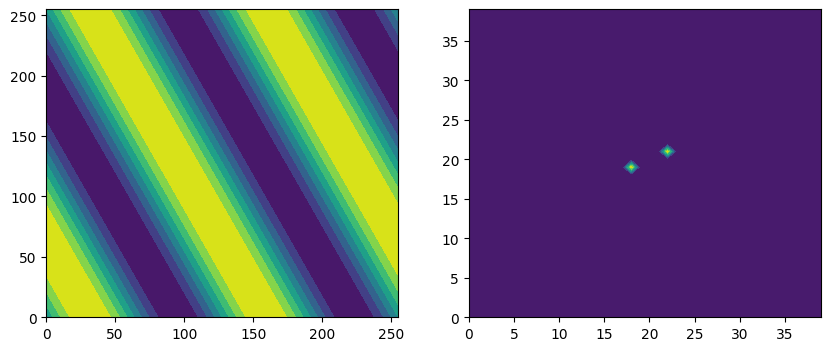

In [7]:
hlfpt = int(Npts/2)
window = 20 

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].contourf(f12)
ax[1].contourf(f12freq[hlfpt-window:hlfpt+window, hlfpt-window:hlfpt+window])

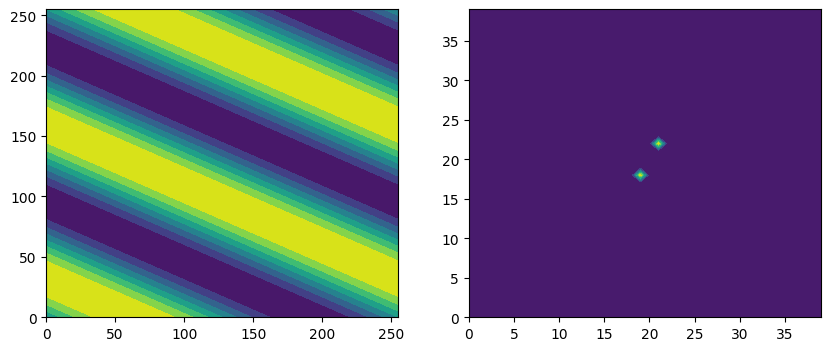

In [8]:
hlfpt = int(Npts/2)
window = 20 

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].contourf(f21)
ax[1].contourf(f21freq[hlfpt-window:hlfpt+window, hlfpt-window:hlfpt+window])

In [15]:
kvec1t = vector_rot(kvec1, np.pi/3)[:, 0]
kvec2t = vector_rot(kvec2, np.pi/3)[:, 0]

In [16]:
f12t, f12freqt = fun_build(xvals, yvals, kvec1t, kvec2t, 1, 2)
f21t, f21freqt = fun_build(xvals, yvals, kvec1t, kvec2t, 2, 1)

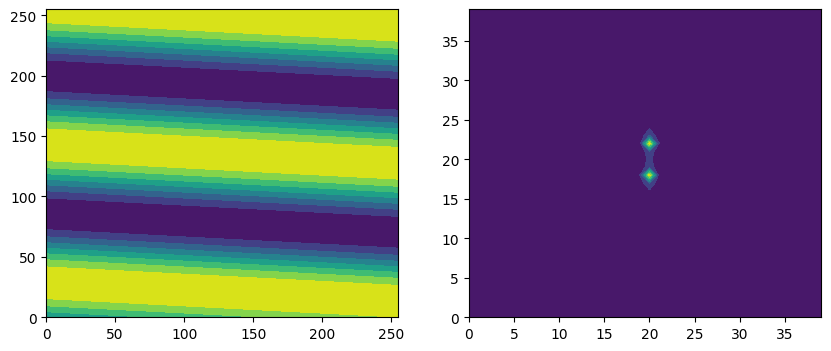

In [18]:
hlfpt = int(Npts/2)
window = 20 

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].contourf(f12t)
ax[1].contourf(f12freqt[hlfpt-window:hlfpt+window, hlfpt-window:hlfpt+window])

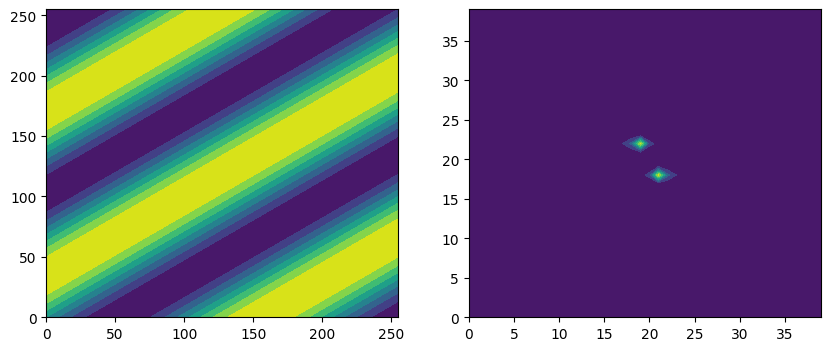

In [19]:
hlfpt = int(Npts/2)
window = 20 

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].contourf(f21t)
ax[1].contourf(f21freqt[hlfpt-window:hlfpt+window, hlfpt-window:hlfpt+window])